In [27]:
%matplotlib inline 

In [28]:
from random import randint

import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

from load_data import get_training_data, test_data_generator, get_validation_data, data_generator, get_test_data

In [29]:
training_data = get_training_data()
test_data = get_test_data()
validation_data = get_validation_data()

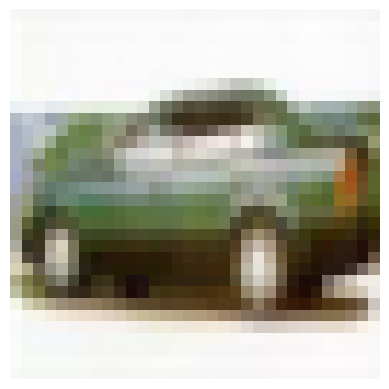

In [30]:
random_index = randint(0, len(training_data["data"]) - 1)
img = training_data["data"][random_index]

# Separate the color channels
red = img[0:1024].reshape((32, 32))
green = img[1024:2048].reshape((32, 32))
blue = img[2048:3072].reshape((32, 32))

# Stack channels along the third dimension
img_rgb = np.stack((red, green, blue), axis=2)

# Display the image
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

In [31]:
# Limit GPU memory growth
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [32]:
# Define the number of classes and image size
num_classes = 10
image_size = 32

In [ ]:
train_generator = data_generator(
    training_data["data"], training_data["labels"], image_size, image_size, batch_size=8
)
validation_generator = data_generator(
    validation_data["data"],
    validation_data["labels"],
    image_size,
    image_size,
    batch_size=8,
)

In [34]:
# Fit the model using the generator
steps_per_epoch = len(training_data["data"]) // 16
validation_steps = len(validation_data["data"]) // 16
num_epochs = 10
learning_rate = 0.001

Epoch 1/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 71s 21ms/step - accuracy: 0.1745 - loss: 2.4201 - val_accuracy: 0.2314 - val_loss: 2.0926
Epoch 2/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 51s 20ms/step - accuracy: 0.2572 - loss: 2.0579 - val_accuracy: 0.2870 - val_loss: 3.1516
Epoch 3/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 48s 19ms/step - accuracy: 0.2912 - loss: 1.9530 - val_accuracy: 0.2330 - val_loss: 2.4407
Epoch 4/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 51s 20ms/step - accuracy: 0.2535 - loss: 2.0255 - val_accuracy: 0.3132 - val_loss: 1.9284
Epoch 5/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 49s 20ms/step - accuracy: 0.3050 - loss: 1.8787 - val_accuracy: 0.3642 - val_loss: 1.7926
Epoch 6/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 49s 19ms/step - accuracy: 0.3408 - loss: 1.7869 - val_accuracy: 0.3732 - val_loss: 1.7223
Epoch 7/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 49s 19ms/step - accuracy: 0.3402 - loss: 1.7891 - val_accuracy: 0.4180 - val_loss: 1.6011
Epoch 8/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 47s 19ms/step - accuracy: 0.3659 -

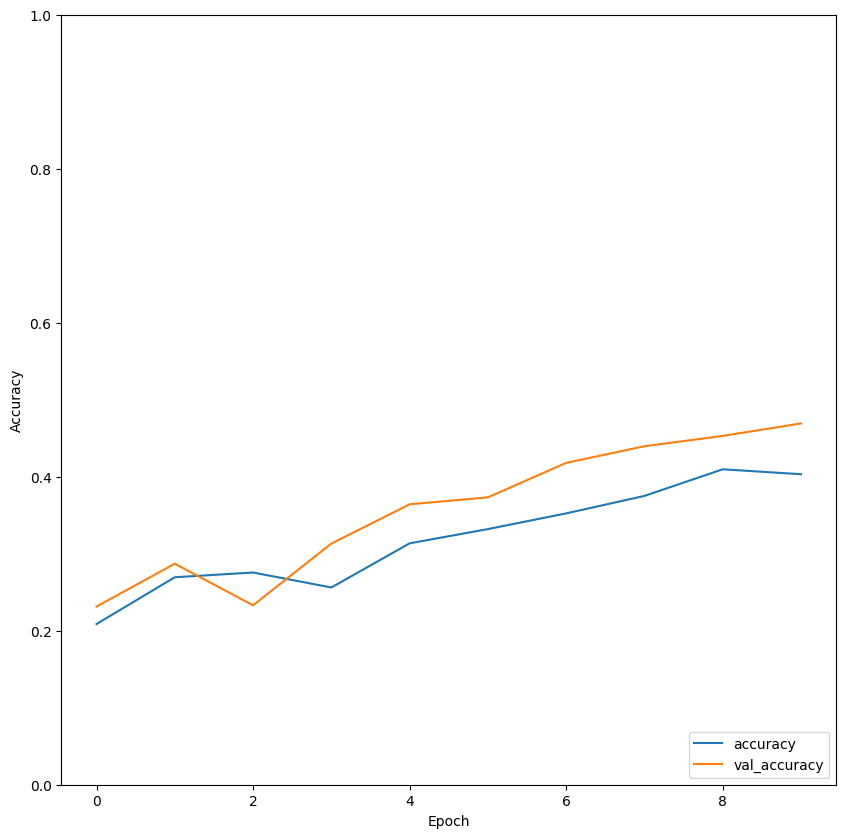

1250/1250 - 18s - 15ms/step - accuracy: 0.4733 - loss: 1.4439
0.4733000099658966


2024-11-07 21:02:26.280817: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2170765361025533014
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-11-07 21:02:26.280893: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14175905901256750634


In [ ]:
from mobilenet import compile_mobilenet_model
mobilenet_model = compile_mobilenet_model(image_size, image_size, num_classes, learning_rate)

model = mobilenet_model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
)

plt.figure(figsize=(10, 10))
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.legend(loc="lower right")
plt.show()

test_generator = test_data_generator(
    test_data["data"], test_data["labels"], image_size, image_size, batch_size=8
)
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(test_acc)

In [ ]:
from mobilenetv2 import compile_mobilenet_v2_model

mobilenet_v2_model = compile_mobilenet_v2_model(
    image_size, image_size, num_classes, learning_rate
)

model = mobilenet_v2_model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
)

plt.figure(figsize=(10, 10))
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.legend(loc="lower right")
plt.show()

test_generator = test_data_generator(
    test_data["data"], test_data["labels"], image_size, image_size, batch_size=8
)
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(test_acc)

Epoch 1/10


Epoch 1/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 99s 21ms/step - accuracy: 0.2257 - loss: 2.1370 - val_accuracy: 0.1070 - val_loss: 2.3065
Epoch 2/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 64s 21ms/step - accuracy: 0.3460 - loss: 1.8023 - val_accuracy: 0.2326 - val_loss: 5.5934
Epoch 3/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 64s 20ms/step - accuracy: 0.3930 - loss: 1.6965 - val_accuracy: 0.1650 - val_loss: 12.3233
Epoch 4/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 64s 21ms/step - accuracy: 0.4268 - loss: 1.5957 - val_accuracy: 0.3426 - val_loss: 3.2402
Epoch 5/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 62s 20ms/step - accuracy: 0.4527 - loss: 1.5331 - val_accuracy: 0.3638 - val_loss: 2.8640
Epoch 6/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 63s 20ms/step - accuracy: 0.4512 - loss: 1.5562 - val_accuracy: 0.4318 - val_loss: 2.1069
Epoch 7/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 63s 20ms/step - accuracy: 0.4593 - loss: 1.5256 - val_accuracy: 0.4522 - val_loss: 1.5867
Epoch 8/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 62s 20ms/step - accuracy: 0.4844 

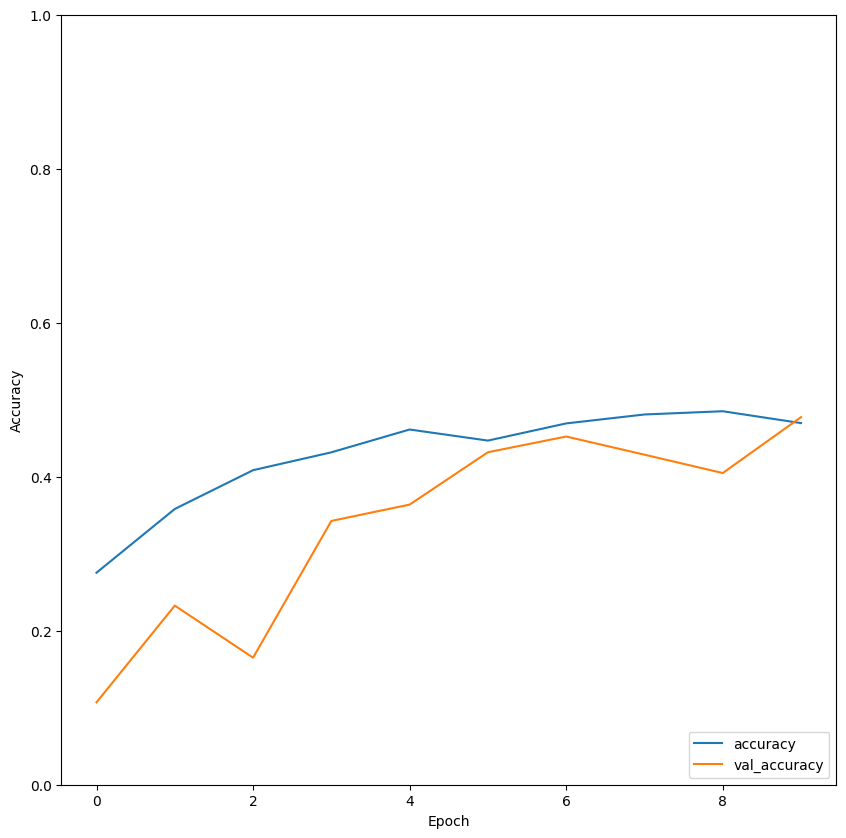

In [ ]:
from mobilenetv3 import compile_mobilenet_v3_model

mobilenet_v3_model = compile_mobilenet_v3_model(
    image_size, image_size, num_classes, learning_rate
)

model = mobilenet_v3_model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
)

plt.figure(figsize=(10, 10))
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.legend(loc="lower right")
plt.show()

test_generator = test_data_generator(
    test_data["data"], test_data["labels"], image_size, image_size, batch_size=8
)
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(test_acc)

Epoch 1/10


/mnt/c/Users/chris/dev/repos/COMP-SCI-7318-Deep-Learning-Fundametals/Assignment2/.venv/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/mnt/c/Users/chris/dev/repos/COMP-SCI-7318-Deep-Learning-Fundametals/Assignment2/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-11-07 17:25:58.950000: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1767_0', 248 by

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 78s 22ms/step - accuracy: 0.2392 - loss: 2.1145 - val_accuracy: 0.3854 - val_loss: 1.6208
Epoch 2/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 65s 21ms/step - accuracy: 0.3973 - loss: 1.6461 - val_accuracy: 0.4822 - val_loss: 1.4503
Epoch 3/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 66s 21ms/step - accuracy: 0.4800 - loss: 1.4608 - val_accuracy: 0.5218 - val_loss: 1.3181
Epoch 4/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 67s 22ms/step - accuracy: 0.5188 - loss: 1.3447 - val_accuracy: 0.5392 - val_loss: 1.2856
Epoch 5/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 67s 21ms/step - accuracy: 0.5523 - loss: 1.2746 - val_accuracy: 0.5836 - val_loss: 1.2000
Epoch 6/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 67s 21ms/step - accuracy: 0.5895 - loss: 1.1720 - val_accuracy: 0.6020 - val_loss: 1.1457
Epoch 7/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 67s 21ms/step - accuracy: 0.6003 - loss: 1.1368 - val_accuracy: 0.6164 - val_loss: 1.1002
Epoch 8/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 67s 22ms/step - accuracy: 0.6352 - loss: 1.04

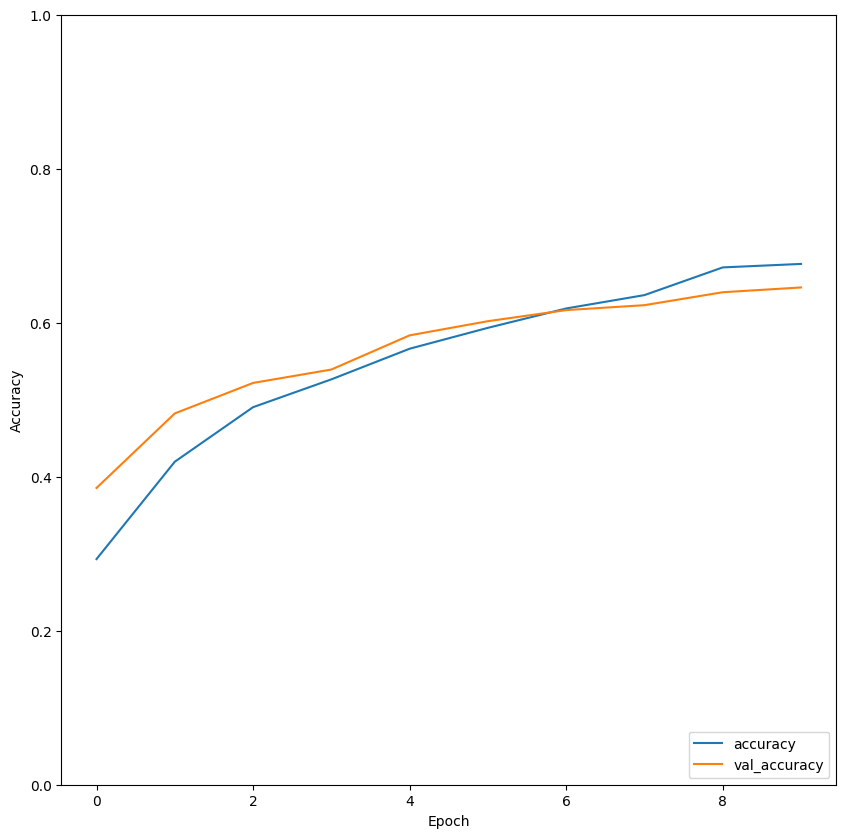

In [ ]:
from alexnet import compile_alexnet_model

alexnet_model = compile_alexnet_model(
    image_size, image_size, num_classes, learning_rate
)

model = alexnet_model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
)

plt.figure(figsize=(10, 10))
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.legend(loc="lower right")
plt.show()

test_generator = test_data_generator(
    test_data["data"], test_data["labels"], image_size, image_size, batch_size=8
)
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(test_acc)

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 52s 19ms/step - accuracy: 0.2466 - loss: 5.9593 - val_accuracy: 0.3840 - val_loss: 2.0291


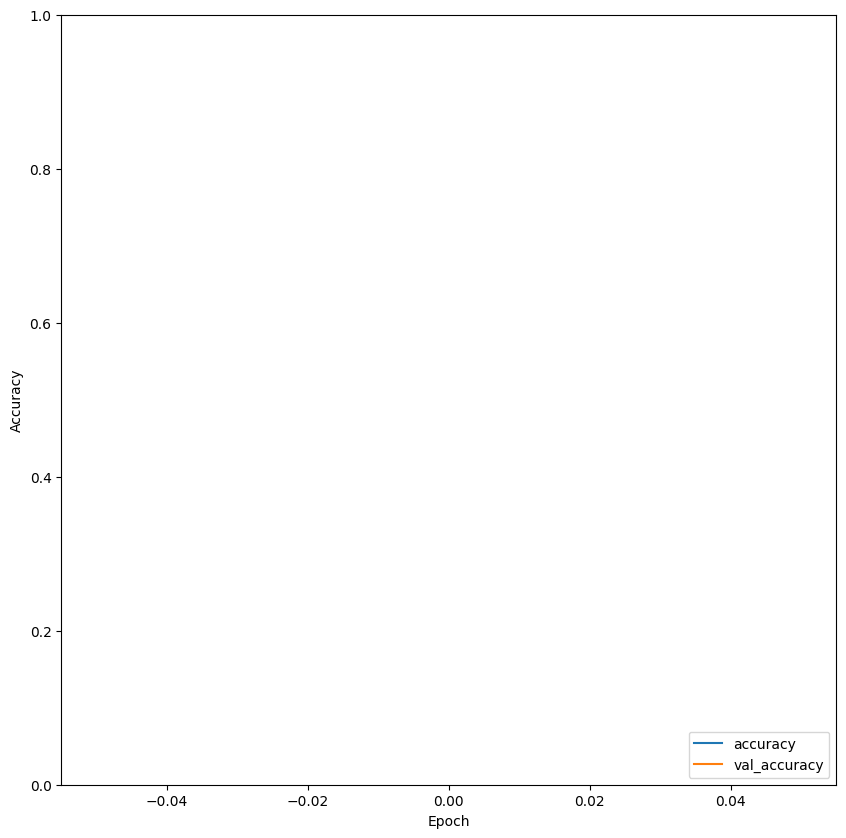

1250/1250 - 15s - 12ms/step - accuracy: 0.3882 - loss: 2.0037
0.3882000148296356


2024-11-07 18:26:19.172420: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-11-07 18:26:19.172471: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-11-07 18:26:19.172482: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2170765361025533014
2024-11-07 18:26:19.172505: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14175905901256

In [ ]:
from resnet18 import compile_resnet_model

resnet_model = compile_resnet_model(num_classes, learning_rate)

model = resnet_model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
)

plt.figure(figsize=(10, 10))
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.legend(loc="lower right")
plt.show()

test_generator = test_data_generator(
    test_data["data"], test_data["labels"], image_size, image_size, batch_size=8
)
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(test_acc)